# 用于验证回测框架的独立程序 (V4 - 事件驱动与固定持仓周期模型)

**目的**: 实现一个全新的回测逻辑，该逻辑遵循“T时刻开仓，T+10时刻平仓”的原则，
完美匹配了模型的预测目标（10个周期）和交易的持仓周期。

**核心变更**:
1.  引入全新的 `run_event_driven_backtest` 函数，取代原有的向量化回测。
2.  回测引擎基于循环，显式管理仓位状态（入场、持仓、出场）。
3.  一笔交易从开仓后，会固定持有 `holding_period`（10个周期），期间忽略新信号。
4.  一笔交易的净盈亏在平仓时被一次性计算并记录。
5.  依然遵循“单利”计算原则。

In [1]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path

---
## 1. 日志和绘图设置

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数 (源于您的代码)

In [3]:
def run_event_driven_backtest(prices, signals, initial_capital, commission_rate, holding_period):
    """
    执行事件驱动的回测，具有固定的持仓周期。
    该函数遵循“T时刻开仓，T+holding_period时刻平仓”的逻辑。
    使用单利模型计算。

    返回:
    - pd.DataFrame: 包含回测结果的DataFrame。
    - list: 包含每笔已完成交易的净收益率的列表。
    """
    logging.info(f"🤔🤔开始执行事件驱动回测 (持仓周期: {holding_period} bars)...")

    # --- 初始化 ---
    market_returns = prices.pct_change().fillna(0)
    
    # pnl_series 用于记录每期由交易活动产生的【收益率】变化
    pnl_series = pd.Series(0.0, index=prices.index)
    
    # positions_series 用于记录每个时间点的实际持仓状态
    positions_series = pd.Series(0, index=prices.index)
    
    # trade_list 用于记录每一笔完整交易的净收益率
    trade_list = []

    # 状态变量
    in_position = False
    position_type = 0  # 1 for long, -1 for short
    entry_time_idx = -1
    exit_time = None

    # --- 主循环 ---
    for i in range(len(prices)):
        current_time = prices.index[i]

        # 1. 检查是否需要平仓
        if in_position and current_time >= exit_time:
            # 计算这笔交易的毛收益率（单利求和）
            gross_pnl_rate = position_type * market_returns.iloc[entry_time_idx + 1 : i + 1].sum()
            
            # 计算总手续费（开仓一次，平仓一次）
            total_commission = 2 * commission_rate
            
            # 计算净收益率
            net_pnl_rate = gross_pnl_rate - total_commission
            
            # 在平仓这一天，记录下这笔交易的全部净收益率
            pnl_series.iloc[i] = net_pnl_rate
            trade_list.append(net_pnl_rate)
            
            logging.info(f"平仓 @ {current_time}: 收益率 = {net_pnl_rate:.4%}")

            # 重置状态
            in_position = False
            position_type = 0
            exit_time = None
            entry_time_idx = -1

        # 2. 如果不在持仓中，检查是否需要开仓
        if not in_position:
            current_signal = signals.iloc[i]
            if current_signal in [1, -1]:
                # 设置新仓位的状态
                in_position = True
                position_type = current_signal
                entry_time_idx = i
                
                # 计算预设的平仓时间
                exit_time_idx = min(i + holding_period, len(prices) - 1)
                exit_time = prices.index[exit_time_idx]
                
                logging.info(f"开仓 @ {current_time}: 类型 = {position_type}, 计划平仓 @ {exit_time}")

        # 3. 记录当前时间点的持仓状态
        if in_position:
            positions_series.iloc[i] = position_type
            
    # --- 结果整合 ---
    # 基于单利模型计算权益曲线
    cumulative_pnl = (pnl_series * initial_capital).cumsum()
    equity_curve = initial_capital + cumulative_pnl

    backtest_results = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'position': positions_series,
        'market_returns': market_returns,
        'strategy_net_returns': pnl_series, # 净收益率序列（稀疏）
        'equity_curve': equity_curve
    })
    
    logging.info("🎉🎉事件驱动回测完成。")
    return backtest_results, trade_list

In [4]:
def evaluate_performance(backtest_results, trade_list, evaluation_criteria, initial_capital, factor_data=None):
    logging.info("🤔🤔🤔开始评估策略表现 (事件驱动模型)...")

    equity_curve = backtest_results['equity_curve']
    net_returns = backtest_results['strategy_net_returns'] # 这是稀疏的PnL序列
    market_returns = backtest_results['market_returns']
    positions = backtest_results['position']
    
    # --- 直接使用回测引擎返回的交易列表 (## NEW LOGIC) ---
    trade_returns_series = pd.Series(trade_list)

    # --- 1. 计算核心指标 (基于单利模型) ---
    annualization_factor = 12 
    total_days = (equity_curve.index[-1] - equity_curve.index[0]).days if len(equity_curve) > 1 else 0
    duration_years = total_days / 365.0 if total_days > 0 else 1 

    # 总收益率
    total_return = (equity_curve.iloc[-1] / initial_capital) - 1 if initial_capital != 0 else 0

    # 算术年化收益率
    annualized_return = total_return / duration_years if duration_years > 0 else 0

    # 使用 .sum() 聚合月度收益
    monthly_net_returns = net_returns.resample('M').sum().dropna()
    monthly_market_returns = market_returns.resample('M').sum().dropna()

    # 年化波动率
    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        annualized_volatility = monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        annualized_volatility = 0

    # 最大回撤
    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max
    max_drawdown = abs(drawdown.min())
    end_date_idx = drawdown.idxmin()
    peak_idx = equity_curve.loc[:end_date_idx].idxmax() if end_date_idx is not None else None
    max_drawdown_start_date = peak_idx
    max_drawdown_end_date = end_date_idx

    # 夏普比率
    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        sharpe_ratio = monthly_net_returns.mean() / monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        sharpe_ratio = 0

    # 卡玛比率
    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else 0

    # 交易统计 (直接使用 trade_returns_series)
    winning_trades_pnl = trade_returns_series[trade_returns_series > 0]
    losing_trades_pnl = trade_returns_series[trade_returns_series <= 0]
    total_trades = len(trade_returns_series)
    num_winning_trades = len(winning_trades_pnl)
    num_losing_trades = len(losing_trades_pnl)
    win_rate = num_winning_trades / total_trades if total_trades > 0 else 0
    total_profit_amount_trades = winning_trades_pnl.sum()
    total_loss_amount_trades = abs(losing_trades_pnl.sum())
    profit_loss_ratio = total_profit_amount_trades / total_loss_amount_trades if total_loss_amount_trades > 0 else np.inf
    expectancy = (win_rate * profit_loss_ratio) - (1 - win_rate) if win_rate > 0 and profit_loss_ratio != np.inf else -1
    
    # 每周开仓频率
    num_open_trades = total_trades
    total_weeks = len(pd.date_range(start=equity_curve.index[0], end=equity_curve.index[-1], freq=Week()))
    weekly_trade_frequency = num_open_trades / total_weeks if total_weeks > 0 else 0

    # 索提诺比率
    downside_monthly_returns = monthly_net_returns[monthly_net_returns < 0]
    if not downside_monthly_returns.empty and downside_monthly_returns.std() != 0:
        downside_std = downside_monthly_returns.std()
        sortino_ratio = monthly_net_returns.mean() / downside_std * np.sqrt(annualization_factor)
    else:
        sortino_ratio = 0
        
    # 平均盈利和平均亏损
    average_win = winning_trades_pnl.mean() if num_winning_trades > 0 else 0
    average_loss = losing_trades_pnl.mean() if num_losing_trades > 0 else 0
    
    # 总盈亏金额
    total_pnl_amount = equity_curve.iloc[-1] - initial_capital

    # 逐年收益率
    annual_returns = net_returns.resample('Y').sum()
    annual_returns.index = annual_returns.index.year

    # --- 超额指标计算 (单利模型) ---
    benchmark_pnl_per_period = market_returns * initial_capital
    benchmark_equity = initial_capital + benchmark_pnl_per_period.cumsum()
    excess_monthly_returns_series = (monthly_net_returns - monthly_market_returns).dropna()
    if not excess_monthly_returns_series.empty:
        excess_pnl_curve = (excess_monthly_returns_series * initial_capital).cumsum()
        excess_equity_curve = initial_capital + excess_pnl_curve
    else:
        excess_equity_curve = pd.Series([initial_capital], index=[equity_curve.index[0]])
    total_excess_return = (excess_equity_curve.iloc[-1] / initial_capital) - 1 if not excess_equity_curve.empty else 0
    annualized_excess_return = total_excess_return / duration_years if duration_years > 0 else 0
    excess_volatility = excess_monthly_returns_series.std() * np.sqrt(annualization_factor) if not excess_monthly_returns_series.empty and excess_monthly_returns_series.std() != 0 else 0
    excess_max_drawdown = 0
    if not excess_equity_curve.empty:
        excess_running_max = excess_equity_curve.cummax()
        excess_drawdown = (excess_equity_curve - excess_running_max) / excess_running_max
        excess_max_drawdown = abs(excess_drawdown.min())
    excess_sharpe_ratio = excess_monthly_returns_series.mean() / excess_monthly_returns_series.std() * np.sqrt(annualization_factor) if not excess_monthly_returns_series.empty and excess_monthly_returns_series.std() != 0 else 0

    # 换手率
    # 在事件驱动模型中，换手率可以更简单地计算
    total_turnover_units = total_trades * 2 # 每笔交易开仓+平仓，仓位变化为2
    # 年化换手率可以定义为 年化交易名义价值 / 平均资产
    # 这是一个简化估算
    average_price = backtest_results['close'].mean()
    annualized_turnover = (total_trades * 2 * average_price) / equity_curve.mean() / duration_years if duration_years > 0 else 0

    # --- 2. 打印评估报告 ---
    print("\n" + "="*80)
    print(Fore.CYAN + " " * 15 + "策略性能评估报告 (事件驱动 + 固定持仓周期模型)" + " " * 15 + Style.RESET_ALL)
    print("="*80)
    
    def format_check(name, value, req_value, req_prefix, comp_func):
        status = "✅ 达标" if comp_func(value, req_value) else "❌ 未达标"
        req_str = f"{req_prefix} {req_value}"
        color = Fore.GREEN if comp_func(value, req_value) else Fore.RED
        return [name, f"{value:.4f}", req_str, color + status + Style.RESET_ALL]

    print("\n" + Fore.BLUE + Style.BRIGHT + "="*30 + " 收益指标 " + "="*30 + Style.RESET_ALL)
    sharpe_req = evaluation_criteria['sharpe_ratio']
    calmar_req = evaluation_criteria['calmar_ratio']
    expectancy_req = evaluation_criteria['expectancy']
    
    sharpe_ok = sharpe_ratio > sharpe_req
    calmar_ok = calmar_ratio > calmar_req
    expectancy_ok = expectancy > expectancy_req
    
    profit_plan1_ok = sharpe_ok and calmar_ok
    profit_plan2_ok = expectancy_ok
    profit_ok = profit_plan1_ok or profit_plan2_ok
    
    headers = ["指标名称", "计算结果", "要求", "状态"]
    profit_table = [
        format_check("夏普比率 (Sharpe)", sharpe_ratio, sharpe_req, ">", lambda v, r: v > r),
        format_check("卡玛比率 (Calmar)", calmar_ratio, calmar_req, ">", lambda v, r: v > r),
        format_check("期望收益 (Expectancy)", expectancy, expectancy_req, ">", lambda v, r: v > r)
    ]
    
    print(tabulate(profit_table, headers=headers, tablefmt="grid", stralign="center", numalign="center"))
    
    plan_table = [
        ["方案一 (夏普 & 卡玛)", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_plan1_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["方案二 (期望收益)", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_plan2_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合收益指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print("\n" + tabulate(plan_table, headers=["策略方案", "状态"], tablefmt="grid", stralign="center"))
    
    long_positions_count = len(positions[positions == 1])
    short_positions_count = len(positions[positions == -1])
    total_positions_count = len(positions[positions != 0])
    
    position_table = [
        ["多头持仓周期占比", f"{long_positions_count/total_positions_count:.2%}" if total_positions_count > 0 else "0.00%"],
        ["空头持仓周期占比", f"{short_positions_count/total_positions_count:.2%}" if total_positions_count > 0 else "0.00%"]
    ]
    print("\n" + tabulate(position_table, headers=["持仓统计", ""], tablefmt="grid", stralign="center"))

    print("\n" + Fore.YELLOW + Style.BRIGHT + "="*30 + " 风控与效率指标 " + "="*30 + Style.RESET_ALL)
    mdd_req = evaluation_criteria['max_drawdown']
    freq_req = evaluation_criteria['weekly_frequency']
    
    mdd_ok = max_drawdown < mdd_req
    freq_ok = weekly_trade_frequency > freq_req
    
    risk_table = [
        format_check("最大回撤 (MDD)", max_drawdown, mdd_req, "<", lambda v, r: v < r),
        format_check("每周开仓频率", weekly_trade_frequency, freq_req, ">", lambda v, r: v > r)
    ]
    
    print(tabulate(risk_table, headers=headers, tablefmt="grid", stralign="center", numalign="center"))
    
    risk_status_table = [
        ["综合风控指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if mdd_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合效率指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if freq_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print("\n" + tabulate(risk_status_table, headers=["指标", "状态"], tablefmt="grid", stralign="center"))

    print("\n" + Fore.GREEN + Style.BRIGHT + "="*30 + " 详细指标 " + "="*30 + Style.RESET_ALL)
    
    detail_headers = ["指标名称", "值"]
    detail_table = [
        ["总收益率 (Total Return)", f"{total_return:.4f}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.4f}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.4f}"],
        ["索提诺比率 (Sortino Ratio)", f"{sortino_ratio:.4f}"],
        ["总盈亏 (Total PnL)", f"{total_pnl_amount:,.2f}"],
        ["总交易笔数 (Total Trades)", f"{total_trades}"],
        ["盈利交易笔数 (Winning Trades)", f"{num_winning_trades}"],
        ["亏损交易笔数 (Losing Trades)", f"{num_losing_trades}"],
        ["胜率 (Win Rate)", f"{win_rate:.4f}"],
        ["盈亏比 (Profit Factor)", f"{profit_loss_ratio:.4f}"],
        ["平均盈利 (Average Win)", f"{average_win:.4f}"],
        ["平均亏损 (Average Loss)", f"{average_loss:.4f}"],
        ["年化换手率 (Annualized Turnover)", f"{annualized_turnover:.4f}"],
        ["最大回撤起始日期", str(max_drawdown_start_date)],
        ["最大回撤结束日期", str(max_drawdown_end_date)]
    ]
    
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))

    print("\n" + Fore.MAGENTA + Style.BRIGHT + "="*30 + " 逐年收益率 " + "="*30 + Style.RESET_ALL)
    annual_returns_df = annual_returns.reset_index()
    annual_returns_df.columns = ["年份", "收益率"]
    annual_returns_df["收益率"] = annual_returns_df["收益率"].apply(lambda x: f"{x:.4f}")
    print(tabulate(annual_returns_df, headers="keys", tablefmt="grid", stralign="center", showindex=False))

    print("\n" + Fore.CYAN + Style.BRIGHT + "="*30 + " 超额指标 " + "="*30 + Style.RESET_ALL)
    excess_table = [
        ["年化超额收益率", f"{annualized_excess_return:.4f}"],
        ["超额波动率", f"{excess_volatility:.4f}"],
        ["超额最大回撤", f"{excess_max_drawdown:.4f}"],
        ["超额夏普比率", f"{excess_sharpe_ratio:.4f}"]
    ]
    print(tabulate(excess_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))

    # --- 3. 绘制权益曲线图 ---
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))
    
    equity_curve.plot(label='Strategy Equity', lw=2, color='royalblue', ax=ax1)
    benchmark_equity.plot(label='Buy & Hold Benchmark', lw=2, linestyle='--', color='darkorange', ax=ax1)
    if not excess_equity_curve.empty:
        excess_equity_curve.plot(label='Excess Equity (vs. Benchmark)', lw=2, linestyle=':', color='forestgreen', ax=ax1)

    ax1.set_title('Strategy, Benchmark & Excess Equity Curves (Event-Driven Model)', fontsize=16)
    ax1.set_ylabel('Equity', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    logging.info("🎊🎊🎊策略评估完成🎊🎊🎊")

---
## 3. 主程序执行

2025-07-23 17:28:06,147 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-23 17:28:06,150 - INFO - 数据加载成功。
2025-07-23 17:28:06,150 - INFO - 🤔🤔开始执行事件驱动回测 (持仓周期: 10 bars)...
2025-07-23 17:28:06,155 - INFO - 开仓 @ 2021-09-27 06:15:00: 类型 = 1, 计划平仓 @ 2021-09-27 08:45:00
2025-07-23 17:28:06,156 - INFO - 平仓 @ 2021-09-27 08:45:00: 收益率 = -0.4784%
2025-07-23 17:28:06,157 - INFO - 开仓 @ 2021-09-27 13:00:00: 类型 = -1, 计划平仓 @ 2021-09-27 15:30:00
2025-07-23 17:28:06,158 - INFO - 平仓 @ 2021-09-27 15:30:00: 收益率 = 0.9134%
2025-07-23 17:28:06,158 - INFO - 开仓 @ 2021-09-27 15:30:00: 类型 = -1, 计划平仓 @ 2021-09-27 18:00:00
2025-07-23 17:28:06,159 - INFO - 平仓 @ 2021-09-27 18:00:00: 收益率 = -0.1710%
2025-07-23 17:28:06,159 - INFO - 开仓 @ 2021-09-27 22:30:00: 类型 = -1, 计划平仓 @ 2021-09-28 01:00:00
2025-07-23 17:28:06,160 - INFO - 平仓 @ 2021-09-28 01:00:00: 收益率 = 2.1483%
2025-07-23 17:28:06,160 - INFO - 开仓 @ 2021-09-28 01:45:00: 类型 = -1, 计划平仓 @ 2021-09-28 04:15:00
2025-07-23 17:28:06,161 - INFO - 平仓 @ 2021


               策略性能评估报告 (事件驱动 + 固定持仓周期模型)               

============================== 收益指标 ==============================
+-----------------------+------------+--------+-----------+
|       指标名称        |  计算结果  |  要求  |   状态    |
+=======================+============+========+===========+
|   夏普比率 (Sharpe)   |  -1.4928   | > 2.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
|   卡玛比率 (Calmar)   |  -0.2607   | > 5.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
| 期望收益 (Expectancy) |  -0.0936   | > 0.25 | ❌ 未达标 |
+-----------------------+------------+--------+-----------+

+----------------------+-----------+
|       策略方案       |   状态    |
+======================+===========+
| 方案一 (夏普 & 卡玛) | ❌ 未达标 |
+----------------------+-----------+
|  方案二 (期望收益)   | ❌ 未达标 |
+----------------------+-----------+
|     综合收益指标     | ❌ 未达标 |
+----------------------+-----------+

+------------------+--------+
|     持仓统计     |        |
+================

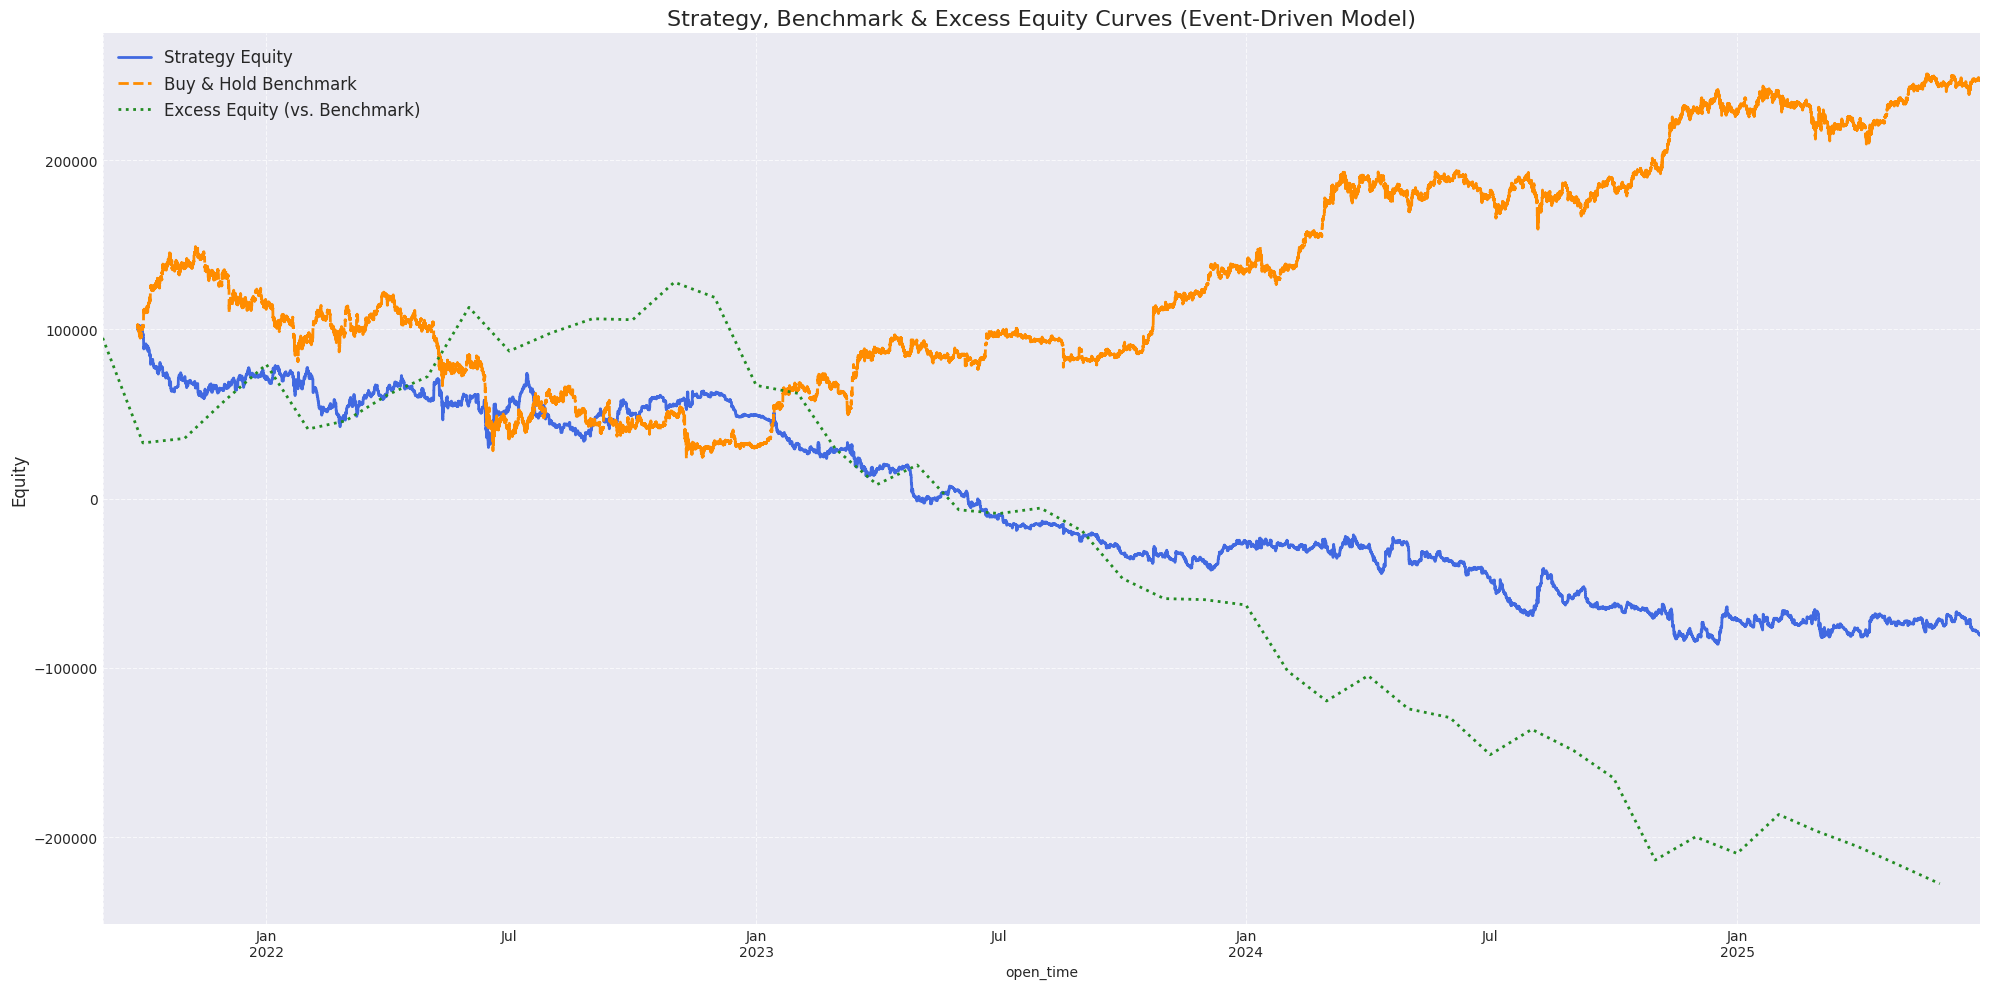

2025-07-23 17:28:29,823 - INFO - 🎊🎊🎊策略评估完成🎊🎊🎊


In [5]:
if __name__ == '__main__':
    # --- 参数配置 ---
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    COMMISSION_RATE = 0.0002
    INITIAL_CAPITAL = 100000
    HOLDING_PERIOD = 10  # !! NEW !!: 核心参数，定义了每笔交易的持仓周期
    
    EVALUATION_CRITERIA = {
        'sharpe_ratio': 2.0,
        'calmar_ratio': 5.0,
        'expectancy': 0.25,
        'max_drawdown': 0.20,
        'weekly_frequency': 0.5 # 频率会降低，调整预期
    }

    # --- 步骤 1: 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    try:
        backtest_data = pd.read_pickle(FILE_PATH)
        # 关键: 这里的 signal 列已经是 T-1 时刻对未来的预测，可以直接用于 T 时刻的开仓决策
        # 无需再 shift(1)
        logging.info("数据加载成功。")
    except FileNotFoundError:
        logging.error(f"错误: 文件未找到 at {FILE_PATH}. 请确认路径是否正确。")
        exit()

    # --- 步骤 2: 执行回测 (调用全新的事件驱动回测引擎) ---
    backtest_results, trade_list = run_event_driven_backtest(
        prices=backtest_data['close'],
        signals=backtest_data['signal'],
        initial_capital=INITIAL_CAPITAL,
        commission_rate=COMMISSION_RATE,
        holding_period=HOLDING_PERIOD
    )
    
    # --- 步骤 3: 性能评估 ---
    evaluate_performance(
        backtest_results=backtest_results,
        trade_list=trade_list, # 传入单笔交易列表
        evaluation_criteria=EVALUATION_CRITERIA,
        initial_capital=INITIAL_CAPITAL,
        factor_data=None 
    )